# Step 1. Build the cell

Here we just have to specify the name of the hoc-template and the morphology, files which should be found in `components/templates/` and `components/morphologies`, respectively.

In this model, the dynamic params are built into the .hoc files so there is no need to specify a **dynamics_params** attribute. Similarly there is no need for axon post-processing in these models so we no longer have a **model_processing** attribute.

The other attributes are optional and can be removed or used for the Hay model specifically.

In [1]:
from bmtk.builder.networks import NetworkBuilder

net = NetworkBuilder('cell')
net.add_nodes(
    N=1,
    model_type='biophysical',
    model_template='hoc:L5PCtemplate.hoc',
    morphology='cell3.asc',
    
    # optional
    # ei_type='exc',
    # model_name='Scnn1a',
    # species='mouse',
    # location='VISp',
    # layer='L4'
)
net.build()
net.save(output_dir='network')


Next, we can add synaptic inputs like we did in the workshop. Note that some properties like **target_sections** and **syn_weight** can and should be adjusted according to the target model type.

In [2]:
virt_exc = NetworkBuilder('virt_exc')
virt_exc.add_nodes(
    N=20,
    model_type='virtual',
    ei_type='exc'
)
conns = virt_exc.add_edges(
    source=virt_exc.nodes(),
    target=net.nodes(),
    connection_rule=12,
    model_template='Exp2Syn',
    dynamics_params='AMPA_ExcToExc.json',
    distance_range=[0.0, 1.0e20],
    target_sections=['soma', 'basal', 'apical'],
    delay=2.0,
    syn_weight=0.01
)

virt_exc.build()
virt_exc.save(output_dir='network')

# Step 2: Running the model

To create a cell object from the L5PCtemplate.hoc, we need some specialized code to load in the NEURON template. To do that, we create a special function called loadHayModel that includes customized Python instructions for initializing and building our cell. 

We use the custom Python **decorator** `@bionet.cell_model` to tell BMTK that whenever a cell has **model_template=hoc:L5PCtemplate.hoc"**, it should call the `loadHayModel` function, which will build the cell and return it as a HOC object. We can also use the `cell_model` template for loading other models, if necessary.

In [1]:
from bmtk.simulator import bionet
from neuron import h


h.load_file("import3d.hoc")

@bionet.cell_model(directive='hoc:L5PCtemplate.hoc', model_type='biophysical')
def loadHayModel(cell, template_name, dynamics_params):
    morphology_file = cell['morphology']
    hobj = h.L5PCtemplate(str(morphology_file))
    return hobj

After that the simulation can be ran like normal

In [ ]:
from bmtk.simulator import bionet

bionet.reset()
# conf = bionet.Config.from_json('config.iclamp.json')
conf = bionet.Config.from_json('config.with_syns.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2024-04-29 11:29:02,857 [INFO] Created log file


NEURON: Import3d_Section : a template cannot be redefined
 in import3d/import3d_sec.hoc near line 1
 begintemplate Import3d_Section
                              ^
        xopen("import3d/i...")
      xopen("import3d.hoc")
    execute1("{xopen("im...")
  load_file("/local1/wo...")
NEURON: Im is not a MECHANISM
 in L5PCbiophys4.hoc near line 22
   	insert Im 
            ^
        xopen("L5PCbiophy...")
  

NEURON mechanisms not found in ./components/mechanisms.


    execute1("{xopen("L5...")
    load_file("L5PCbiophy...")


2024-04-29 11:29:03,148 [INFO] Building cells.


Like with the Allen Institute model, the Hay NEURON model will record variables like spikes, membrane traces, and other parameters that BMTK will instruct it to. The output is in the same format, and thus, we can read it like with the models we used in the workshop.

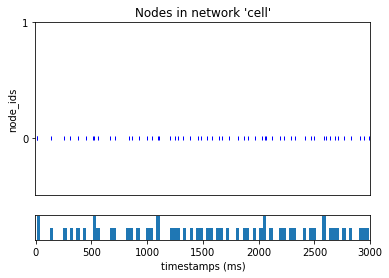

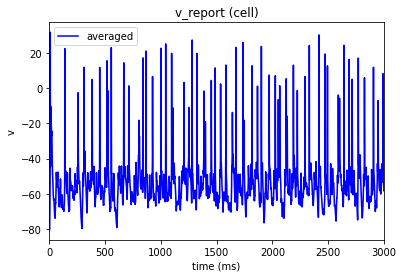

In [11]:
from bmtk.analyzer.spike_trains import plot_raster
from bmtk.analyzer.compartment import plot_traces

_ = plot_raster(config_file='config.with_syns.json')
_ = plot_traces(config_file='config.with_syns.json', report_name='v_report')